In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import random
import copy

In [0]:
torch.set_printoptions(precision=10)

manualSeed = 1

def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(manualSeed)

In [0]:
n = 2
first, last = [-1., 1.]

In [0]:
def plot_cheb_approxim(orig_p, num_Tk):
    f, axes = plt.subplots(1,1, figsize=(10, 10), dpi=60, facecolor='w', edgecolor='k')
    npoints = 50
    x = np.linspace(first, last, 100)
    y = orig_p(x)
    cheb_p = p = np.polynomial.Chebyshev.fit(x, y, num_Tk)

    axes.plot(x, y, 'r.')
    axes.plot(x, p(x), 'k-', lw=3)
    plt.show()

# Create Datapoints

In [0]:
def create_data_cheb(d, orig_p):
    cheb_n = np.zeros(d)
    for i in reversed(range(0,d)):
        cheb_n[i] = np.cos(np.pi*(i)/(d-1))
    cheb_n = (last-first)*(np.copy(cheb_n) + 1)/(1.*2) + first
    ys = torch.tensor(orig_p(cheb_n)).float().view(d,1)
    xs = torch.tensor(cheb_n).float().view(d,1)
    return xs, ys


# DNN approximating $x^2$ and $xy$

In [0]:
class Net_x2(nn.Module):
    def __init__(self, n, d, epsilon, a=0., b=1., w1=None, b1=None, p_k=None):
        super(Net_x2, self).__init__()
        self.n = n
        self.iter = int(np.log(1/epsilon))
        #self.lrelu = nn.LeakyReLU(0.1)
        print("number of h compositions %d" % self.iter)
        self.xrange = np.arange(first, last, 0.0005)
        self.a = a
        self.b = b
        self.c = (b-a)**2/4.
        
    def h(self, x):
        return 2*F.relu(x) - 4*F.relu(x-0.5) + 2*F.relu(x-1)

    def g1(self, x):
        return 2/(self.b-self.a)*F.relu(x-self.a) - 4/(self.b-self.a)*F.relu(x-(self.a+self.b)/2.) + 2/(self.b-self.a)*F.relu(x-self.b)
    
    def h_leaky(self, x):
        return 2*self.lrelu(x) - 4*self.lrelu(x-0.5) + 2*self.lrelu(x-1)
    
    def forward(self, x, plot=False):
        out = F.relu((self.a+self.b)*x - self.a*self.b)
        x = self.g1(x)
        
        if plot:
            test_x = torch.tensor(self.xrange).float().view(self.xrange.shape[0],1)
            plt.plot(self.xrange, test_x.data.numpy(), label='level 00')
            nn_ys = F.relu((self.a+self.b)*test_x - self.a*self.b).data.numpy()
            test_x = self.g1(test_x)
    
        
        for j in range(self.iter):
            
            out = out - self.c*x*(2.0**(-(j)*self.n))

            if plot:                
                nn_ys = nn_ys - (self.c*test_x*(2.0**(-(j)*self.n))).data.numpy()
                plt.plot(self.xrange, (test_x*(2.0**(-(j)*self.n))).data.numpy(), ':', label='level %d'%j)
                plt.plot(self.xrange, nn_ys, label='out %d'%j)
                test_x = self.h(test_x)
            x = self.h(x)

        return out

class Net_xy(torch.nn.Module):
    def __init__(self, n, d, epsilon, a=0., b=1.):
        super(Net_xy, self).__init__()
        self.x2 = Net_x2(n, d, epsilon, a=a, b=b)

    def forward(self, xx):
        x = xx[:,:1]
        y = xx[:,1:]
        xy_pred = 0.5*(4*self.x2(0.5*(x+y))-self.x2(x)-self.x2(y))
        return xy_pred

# DNN approximating Chebyshev polynomials

$p_n(x) = \sum_{k \in [n]} c_k T_k(x)$

$T_0(x) = 1, \qquad T_1(x) = x, \qquad T_k(x) = 2xT_{k-1}(x) - T_{k-2}(x)$

In [0]:
class Cheb_Net(torch.nn.Module):
    def __init__(self, epsilon, k, a=0., b=1., w_Tk = None, w_coeff = None, mode="Tk_coeff"):
        super(Cheb_Net, self).__init__()
        n = 2
        d = 1
        self.mode = mode
        self.xy = Net_xy(n, d, epsilon,a=a, b=b)
        self.k = k
        print("mode", mode)
        if "Tk" in self.mode:
            ones = torch.ones(k-1,1)
            self.w_Tk = nn.Parameter(torch.stack([ones*2, -1*ones], dim=1).squeeze())
        self.w_coeff = nn.Parameter(torch.randn(1,k+1))

        if "Tk_set" in self.mode:
            weights = self.w_Tk
            weights.data = torch.FloatTensor(w_Tk.reshape(weights.data.size()))

        if "coeff" in self.mode:
            weights = self.w_coeff
            weights.data = torch.FloatTensor(w_coeff.reshape(weights.data.size()))


    def forward(self, x):
        T0 = x*0+1
        T1 = x
        out = self.w_coeff[0,0]*T0 + self.w_coeff[0,1]*T1

        for i in range(self.k-1):
          xT1 = self.xy(torch.stack([x, T1], dim=1).squeeze())
          if "Tk" in self.mode:
            # learn coefficients for constructing Chebyshev polynomial Tk
            Tk = self.w_Tk[i,0]*(xT1) + self.w_Tk[i,1]*(T0)
          else:
            # use true coefficients (2, -1)
            Tk = 2*xT1 - T0

          out = out + self.w_coeff[0,i+2]*(Tk)
          T0 = T1
          T1 = Tk

        return out

In [0]:
def plot_p_nn(net, i, axes, idx):
    x = np.arange(first, last, 0.0005)
    xs = torch.tensor(x).float().view(x.shape[0],1)
    nn_ys = net(xs).data.numpy()
    axes[idx].plot(x, nn_ys, '--', label='nn, %d iter'%i)

def plot_p_nn_vs_cheb(net, net_untrained, cheb_p, orig_p, axes, idx):
          xs, ys = create_data_cheb(200, orig_p)
          nn_ys = net(xs).data.numpy()
          nn_ys2 = net_untrained(xs).data.numpy()
          axes[idx].plot(xs.numpy().squeeze(), ys.numpy().squeeze(), ':', label='orig_p', color='k', linewidth=3)
          axes[idx].plot(xs.numpy().squeeze(), nn_ys, color='m', label='nn train', linewidth=5, alpha=0.3)
          axes[idx].plot(xs.numpy().squeeze(), nn_ys2, color='b', label='nn 0 iter', linewidth=1, alpha=0.8)
          axes[idx].plot(xs.numpy().squeeze(), cheb_p(xs.numpy().squeeze()), color='g', label='cheb_p', alpha=0.8)
          axes[idx].legend()


def get_approximation_dnn(num_Tk=None, orig_p=None, mode=None, eps=None, npoints=None, train=None, loop=None):
      xs, ys = create_data_cheb(npoints, orig_p)
      p_xs = xs.data.numpy()
      p_ys = ys.data.numpy()
      x =  np.linspace(first, last, npoints)

      k = num_Tk
      y = orig_p(x)
      cheb_p = np.polynomial.Chebyshev.fit(x, y, k)
      Tk_true_coef = cheb_p.coef

      net = Cheb_Net(eps, k, a=first, b=last, w_coeff = Tk_true_coef, mode=mode)
      net_untrained = copy.deepcopy(net)

      criterion = nn.MSELoss()
      #optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
      optimizer = optim.Adam(net.parameters(), lr=0.002)
      if train:
          prev_loss = None
          losses = np.zeros(loop)
          patience = 15; count = 0

          plot_x = np.arange(first, last, 0.0005)
          plot_xs = torch.tensor(plot_x).float().view(plot_x.shape[0],1)

          plot_net_data = []

          for i in range(loop):
              plot_net_data += [net(plot_xs).data.numpy()]
              optimizer.zero_grad()   
              output = net(xs)
              loss = criterion(output, ys)
              losses[i] = loss.data.numpy()

              if i == 0:
                prev_loss = loss

              if prev_loss > loss:            
                  torch.save(net, 'cheb_nn.pt')
                  prev_loss = loss
                  count = 0
              else:
                  if count + 1 > patience:
                    losses = losses[:i+1]
                    break
                  count += 1

              loss.backward()
              optimizer.step()

          f, axes = plt.subplots(3,1, figsize=(10, 30), dpi=60, facecolor='w', edgecolor='k')
          x = np.arange(first, last, 0.0005)
          axes[1].plot(x, orig_p(x), 'k',label='orig_p')

          for i in range(len(plot_net_data)):
              axes[1].plot(x, plot_net_data[i], '--', label='nn, %d iter'%i)
          net = torch.load('cheb_nn.pt')
          axes[0].plot(np.arange(losses.shape[0]), losses, marker='o')
          axes[0].set_title('MSE over iterations, numTk=%d'%num_Tk)
          plot_p_nn(net, loop, axes, 1)
          axes[1].plot(p_xs, p_ys, 'o', color='k', label='data points')
          axes[1].set_title('Function approximation using NN, numTk=%d'%num_Tk)
          


      test_xs, test_ys = create_data_cheb(10000, orig_p)
      output = net(test_xs)
      loss = criterion(output, test_ys).data.numpy()
      print("DNN MSE: ", loss)
      cheb_loss = criterion(torch.tensor(cheb_p(test_xs.numpy())), test_ys).data.numpy()
      print("Cheb pol MSE: ", cheb_loss)


      plot_p_nn_vs_cheb(net, net_untrained, cheb_p, orig_p, axes, 2)
      axes[2].set_title('Approximation function using NN, numTk=%d'%num_Tk)


      plt.show()

      return net, cheb_p, loss, cheb_loss


# Approximation of $f(x) = \frac{1}{1+25x^2}$

In [0]:
orig_p = lambda x: (1+25*x**2)**(-1)

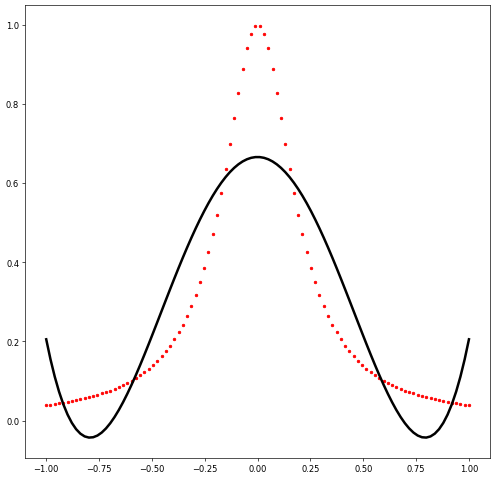

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.012929343
Cheb pol MSE:  0.01536281919712589


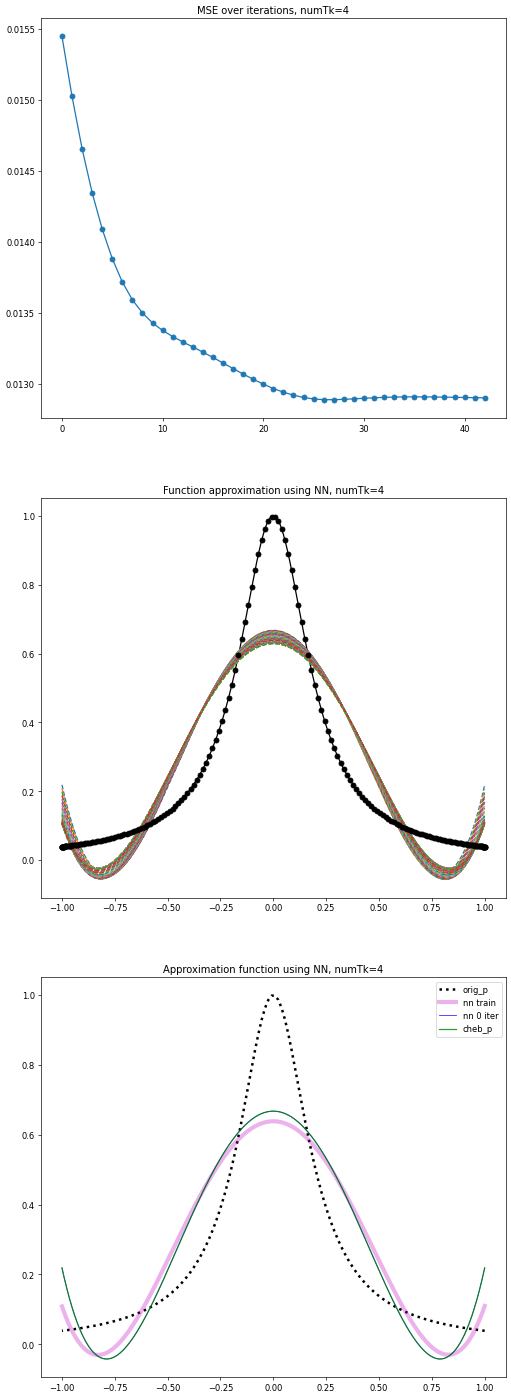

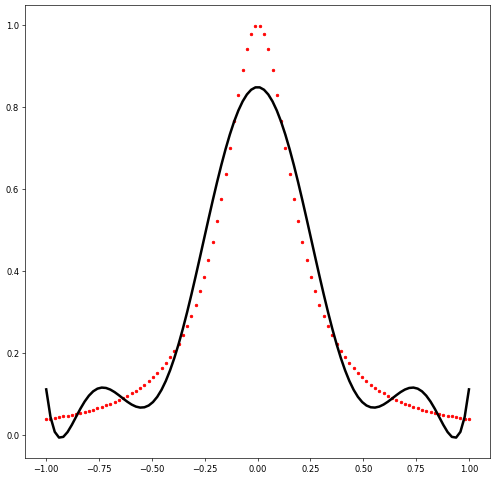

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.0005592511
Cheb pol MSE:  0.003074802407736936


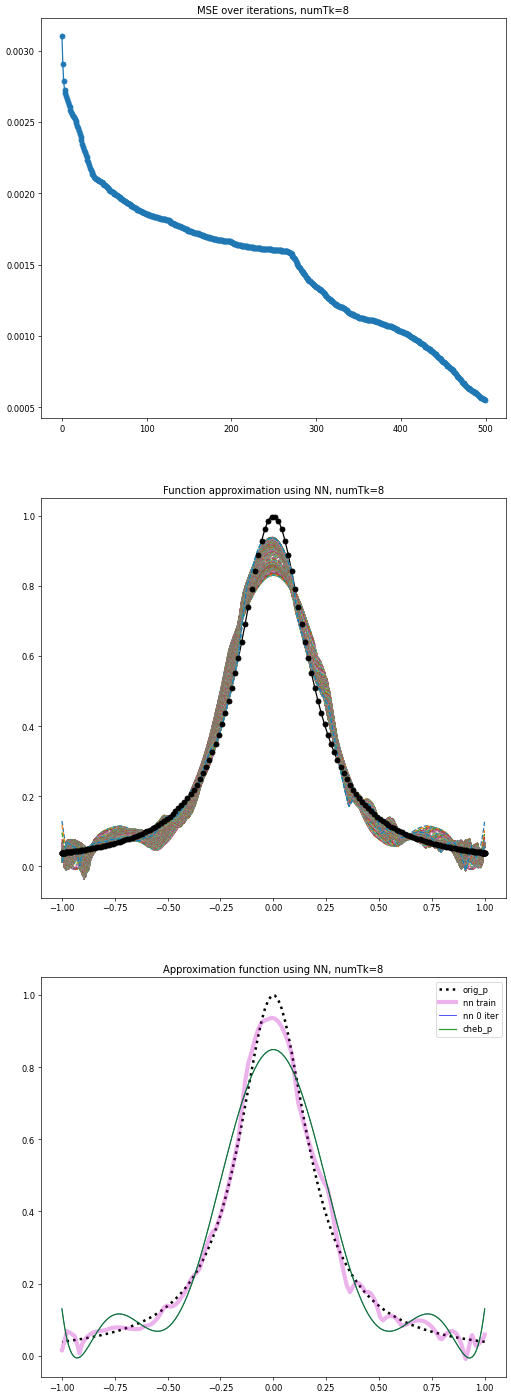

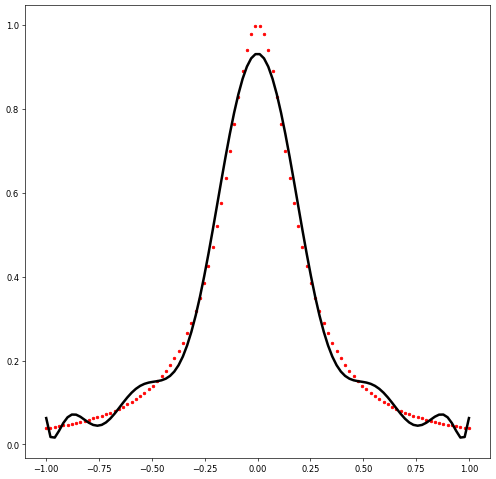

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  9.0503214e-05
Cheb pol MSE:  0.0006041617624825185


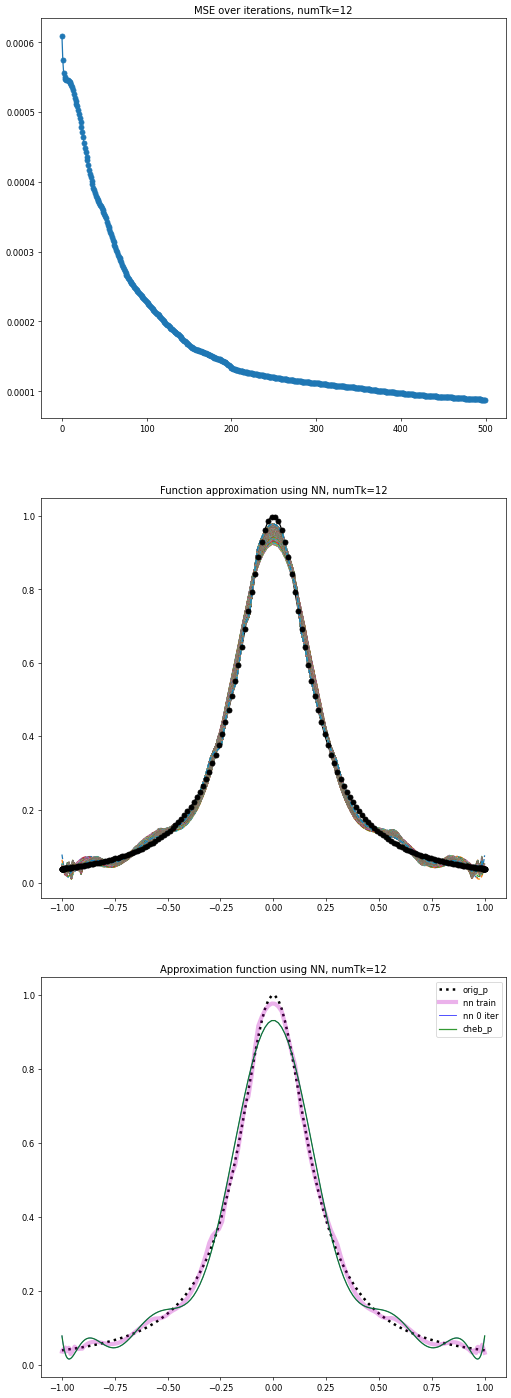

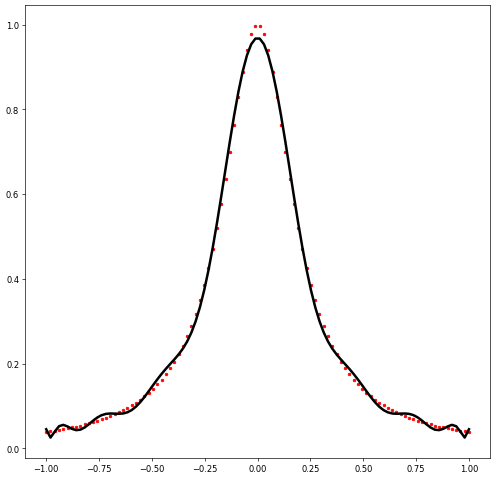

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  5.309618e-05
Cheb pol MSE:  0.0001203696505595568


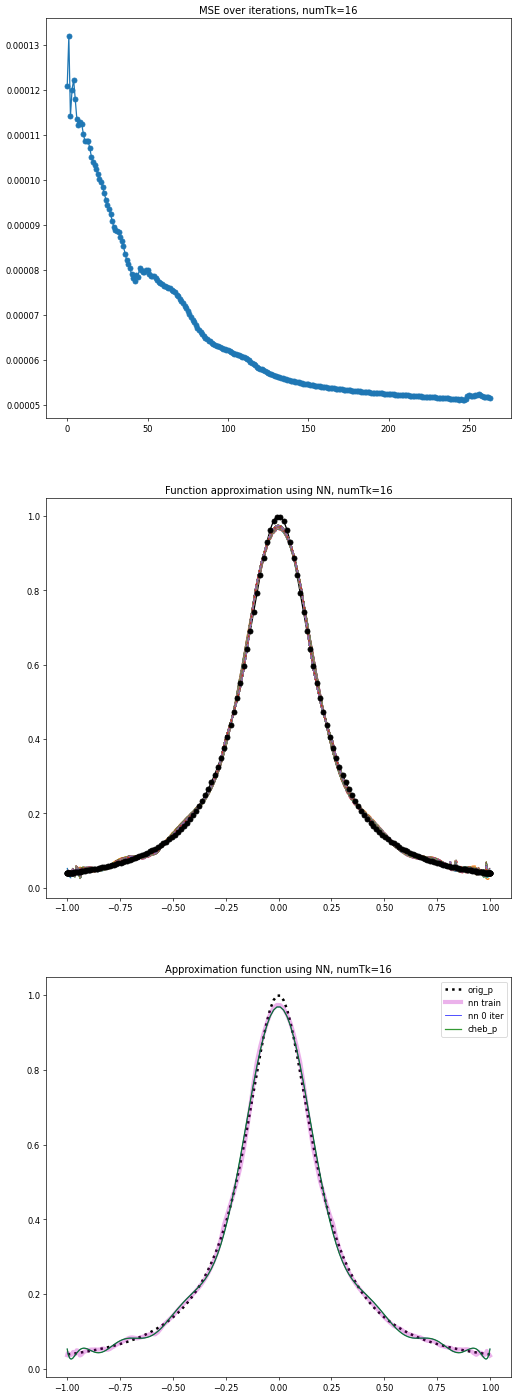

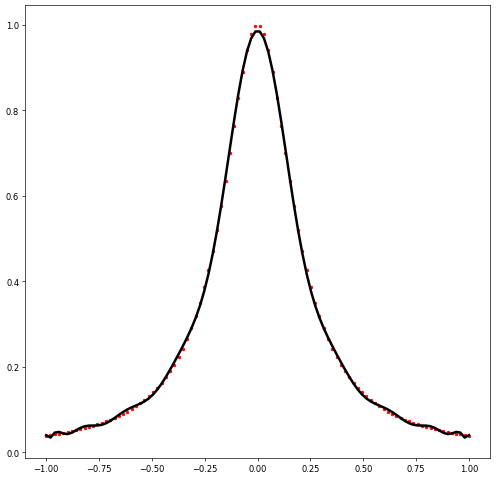

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  1.9803334e-05
Cheb pol MSE:  2.4591563663403843e-05


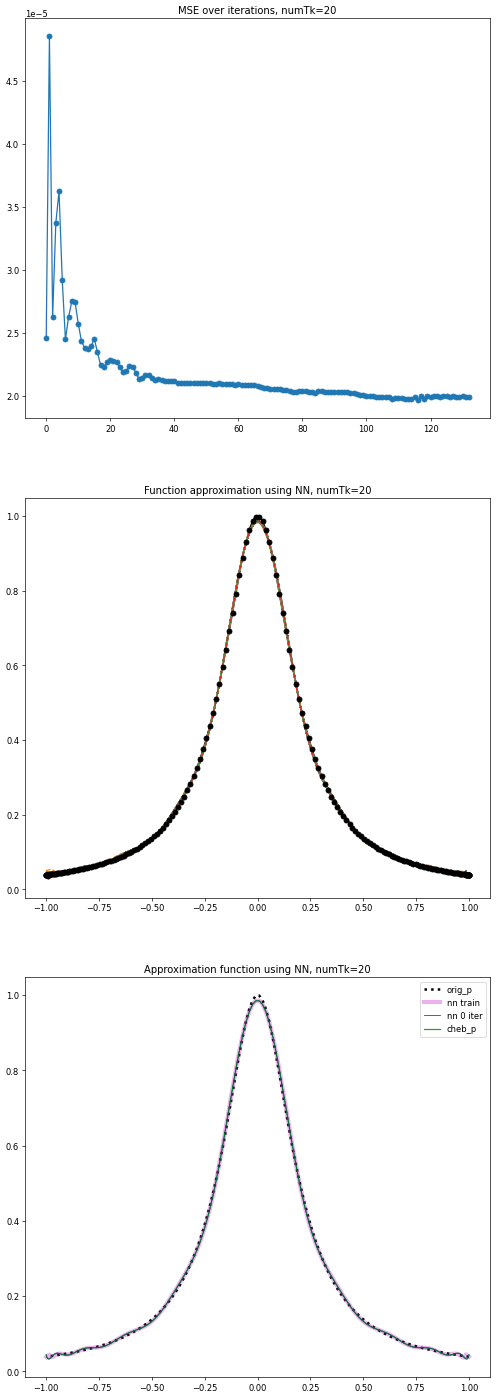

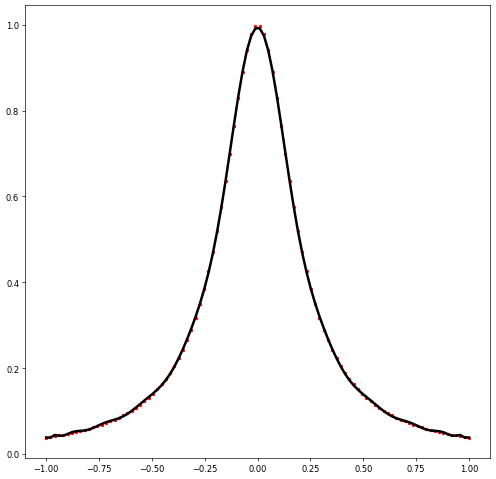

number of h compositions 11
mode Tk_coeff
DNN MSE:  1.9803334e-05
Cheb pol MSE:  5.147549737872383e-06


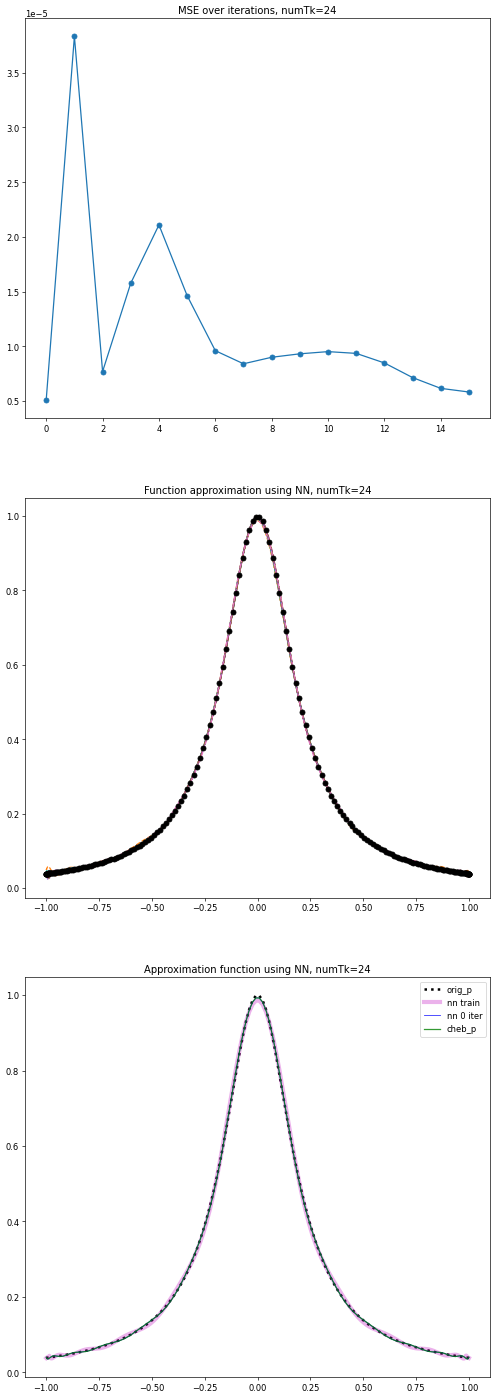

In [0]:
losses_comp = {'nn':[], 'cheb':[]}
for num_Tk in range(4,25,4):
  plot_cheb_approxim(orig_p, num_Tk)
  net, cheb_p, loss, cheb_loss = get_approximation_dnn(num_Tk=num_Tk, orig_p=orig_p, mode="Tk_coeff", eps=0.00001, npoints=200, train=True, loop=500)
  losses_comp['nn'] += [loss]
  losses_comp['cheb'] += [cheb_loss]

[]

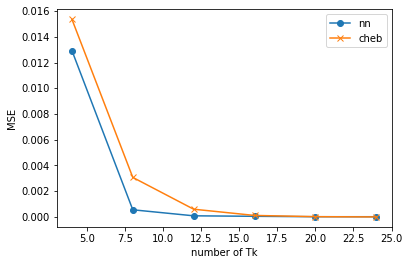

In [0]:
tk_range = np.arange(4,25,4)
plt.plot(tk_range, losses_comp['nn'], marker='o', label='nn')
plt.plot(tk_range, losses_comp['cheb'], marker='x', label='cheb')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('number of Tk')
plt.plot()

# Approximation of $f(x) = \cos(20x)$

In [0]:
orig_p = lambda x: np.cos(20*x)

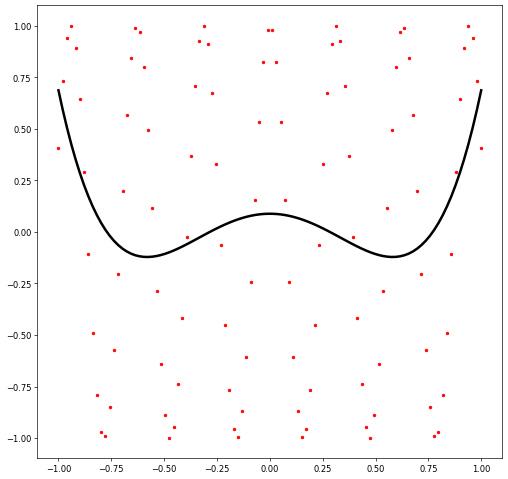

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.38070035
Cheb pol MSE:  0.3904709765982539


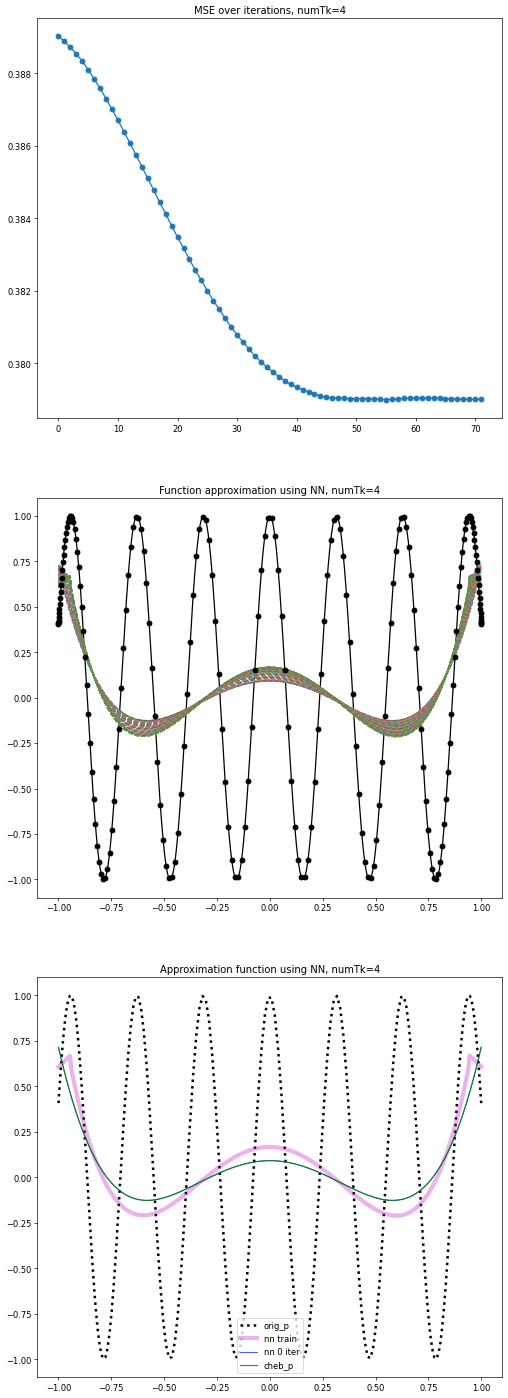

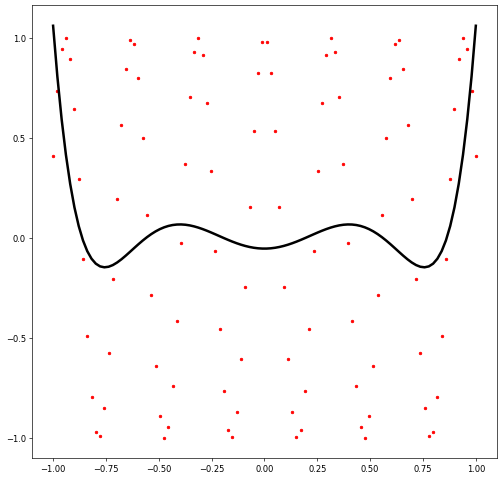

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.094186105
Cheb pol MSE:  0.40504145626363286


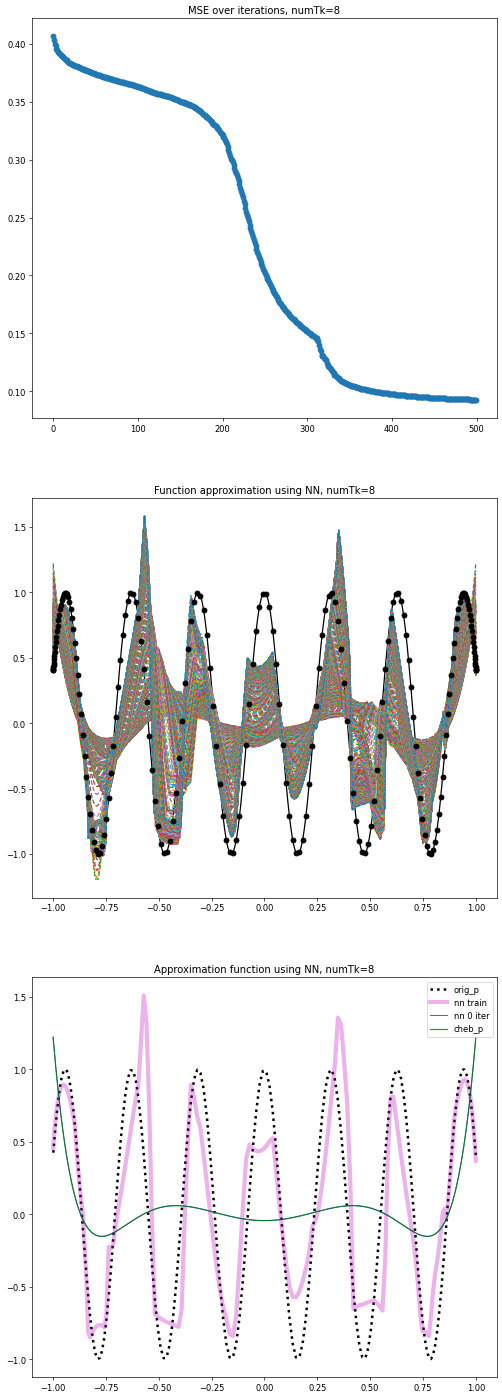

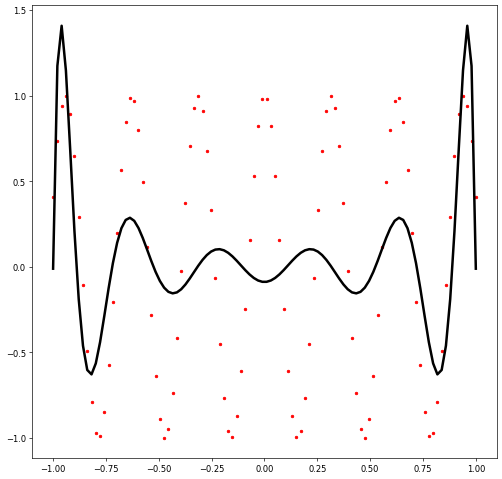

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.032891665
Cheb pol MSE:  0.2902152069394263


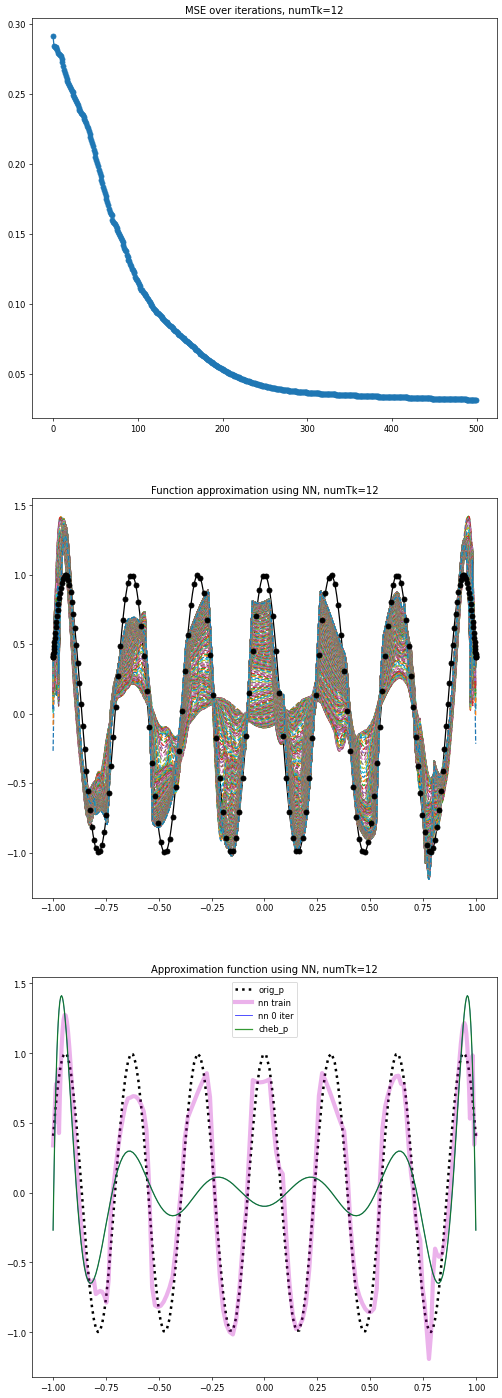

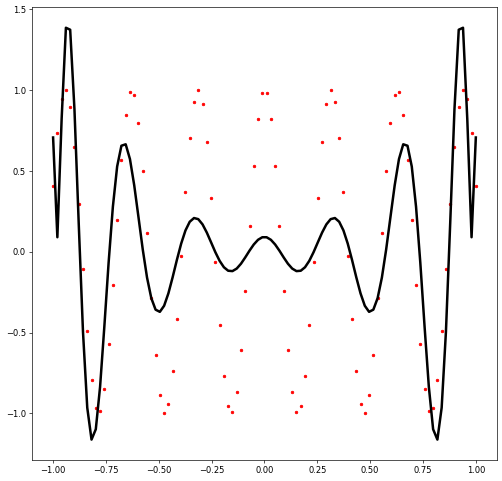

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.07761902
Cheb pol MSE:  0.21247698273255614


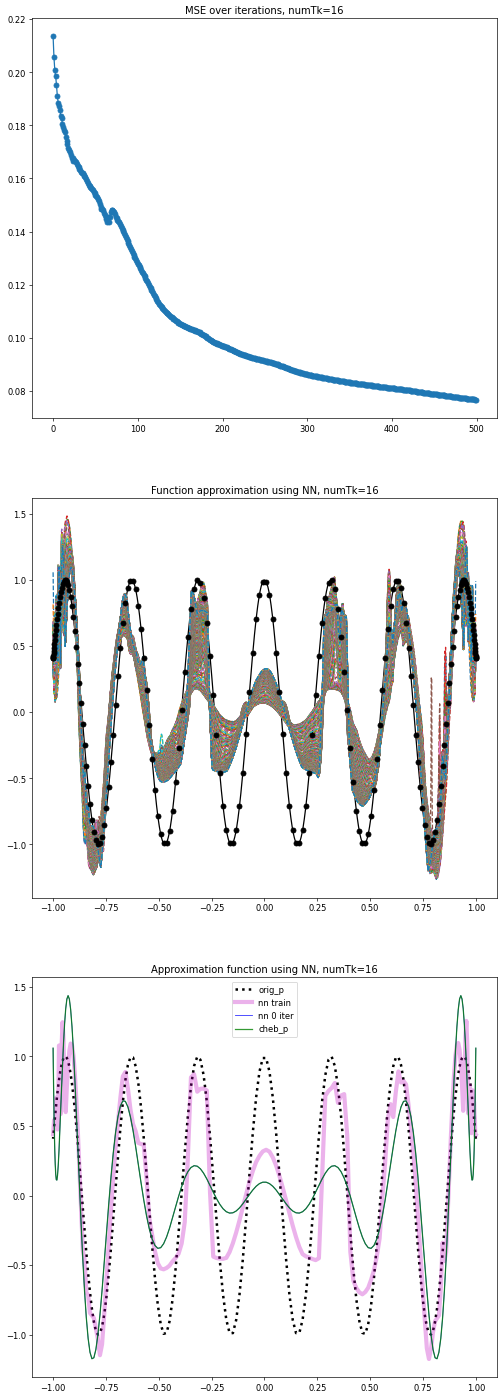

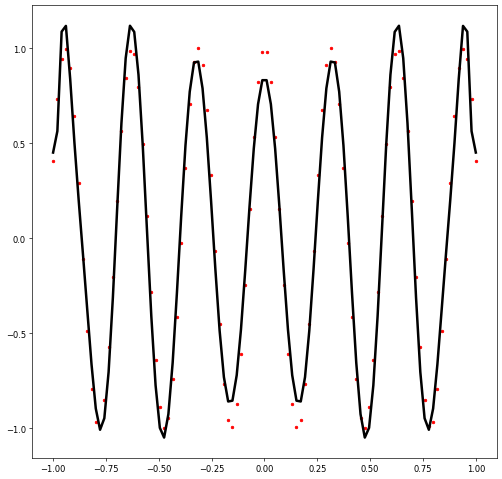

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.004448624
Cheb pol MSE:  0.011832301056024536


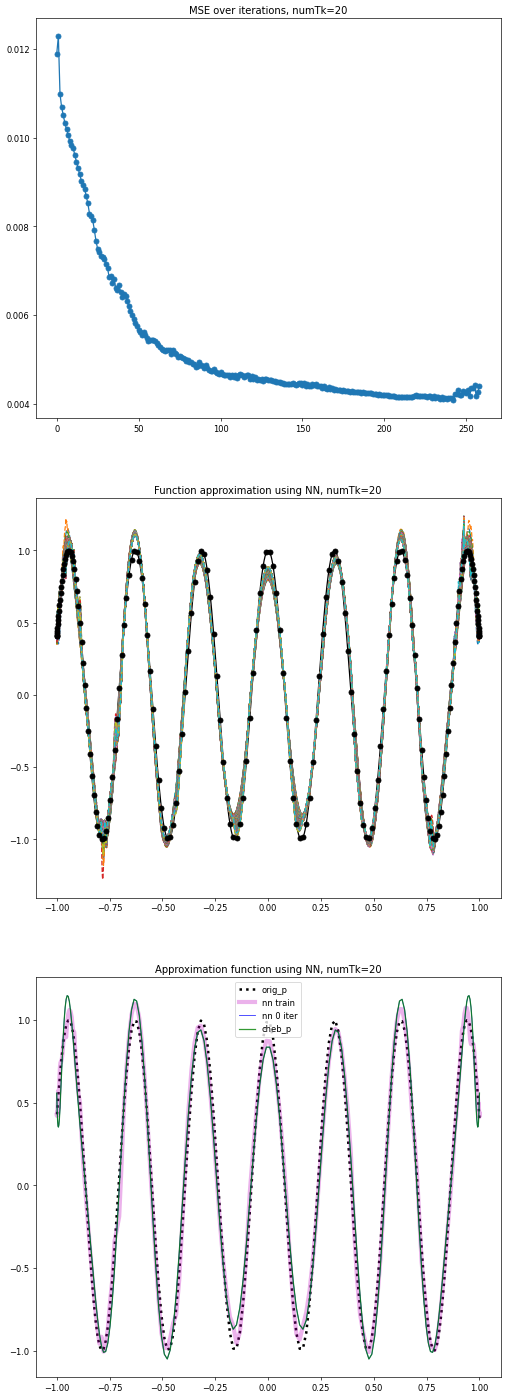

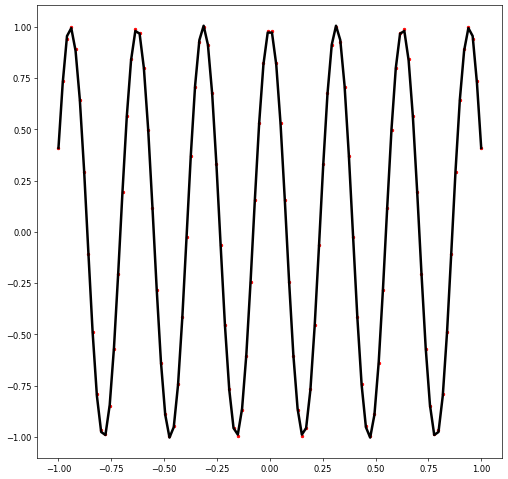

number of h compositions 11
mode Tk_coeff
DNN MSE:  0.004448624
Cheb pol MSE:  5.441989205283263e-05


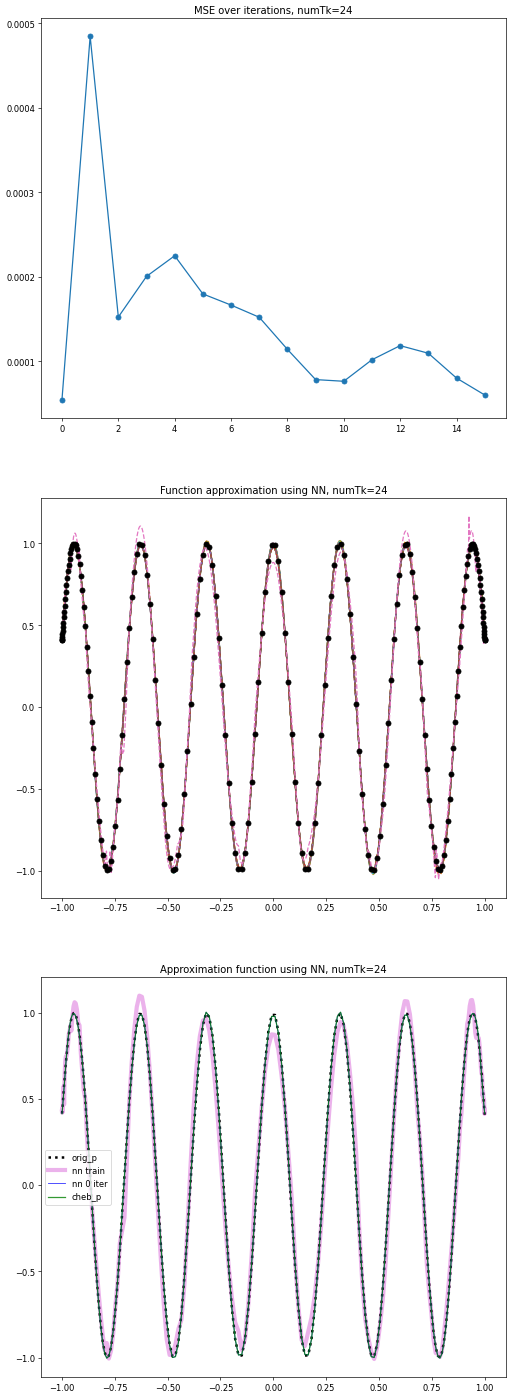

In [0]:
losses_comp = {'nn':[], 'cheb':[]}
for num_Tk in range(4,25,4):
  plot_cheb_approxim(orig_p, num_Tk)
  net, cheb_p, loss, cheb_loss = get_approximation_dnn(num_Tk=num_Tk, orig_p=orig_p, mode="Tk_coeff", eps=0.00001, npoints=200, train=True, loop=500)
  losses_comp['nn'] += [loss]
  losses_comp['cheb'] += [cheb_loss]

[]

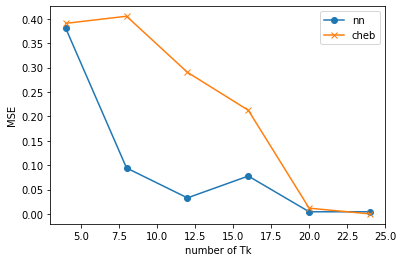

In [0]:
tk_range = np.arange(4,25,4)
plt.plot(tk_range, losses_comp['nn'], marker='o', label='nn')
plt.plot(tk_range, losses_comp['cheb'], marker='x', label='cheb')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('number of Tk')
plt.plot()

# Approximation of $f(x) = \begin{cases}
      1+\frac{1}{2}x^2 & \text{if }x\geq 0\\
      0 & \text{if } x<0
    \end{cases}$

In [0]:
orig_p = lambda x: (1+0.5*x**2)*(x>=0)+ 0*(x<0)

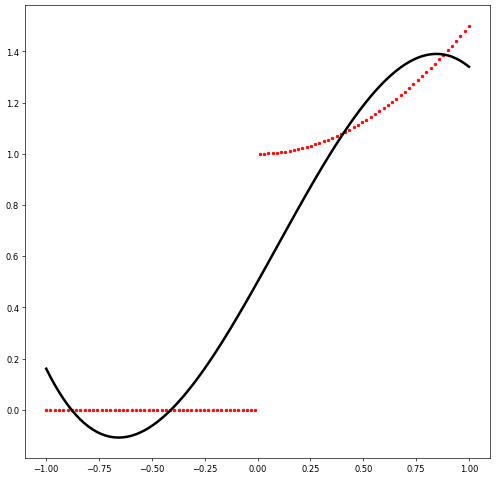

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.023780826
Cheb pol MSE:  0.026181482520264057


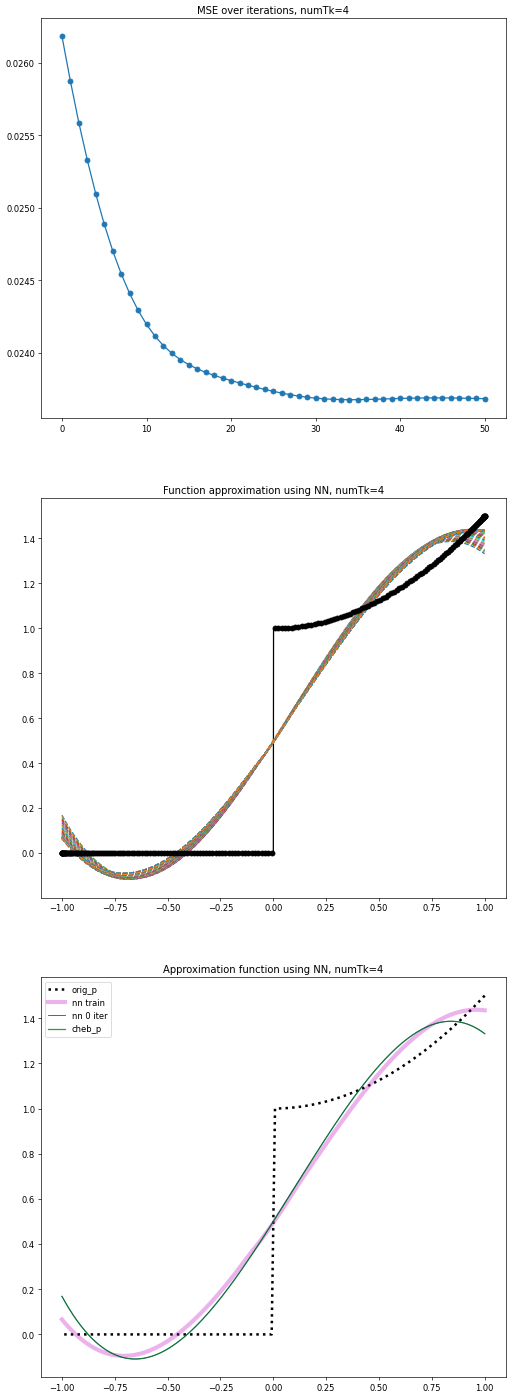

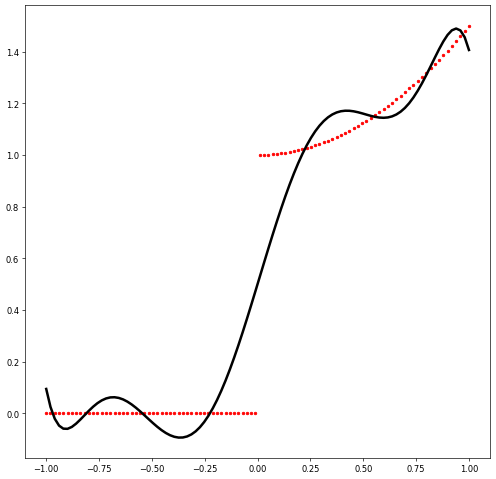

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.0036930805
Cheb pol MSE:  0.01321153235762465


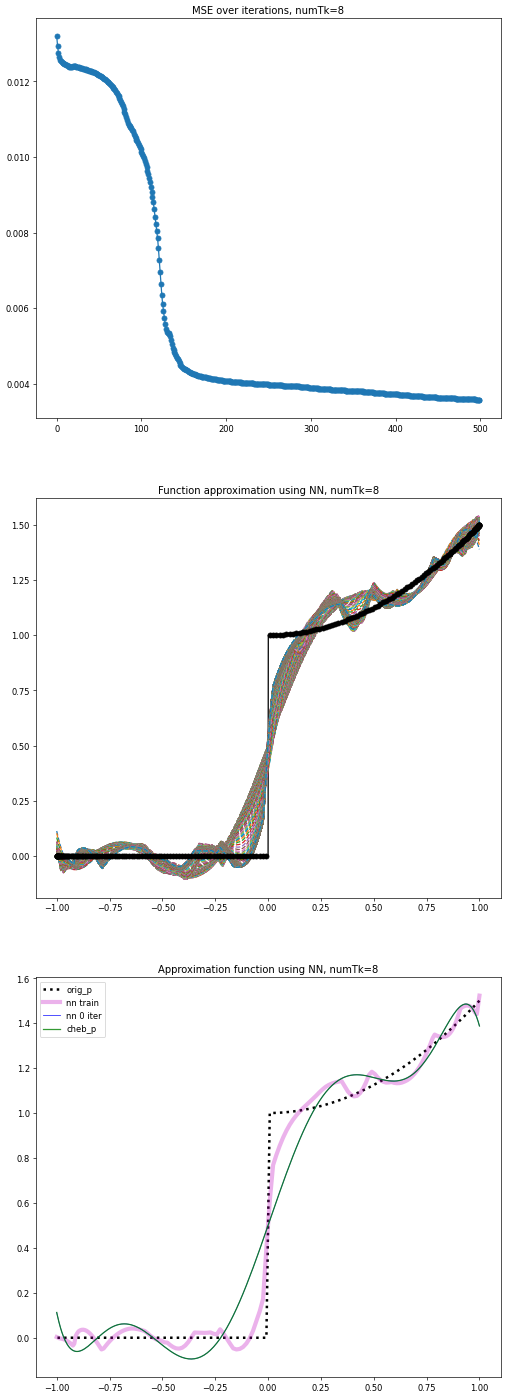

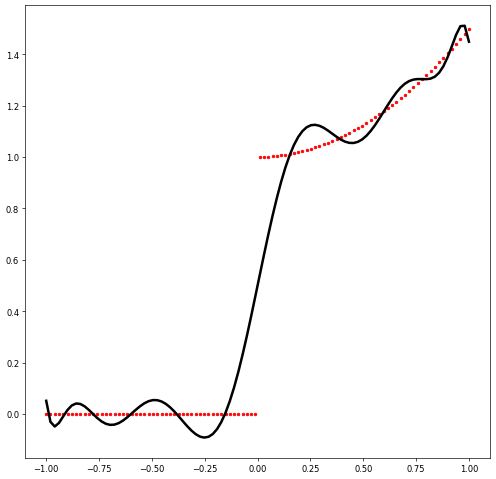

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.0017675482
Cheb pol MSE:  0.008656265205267695


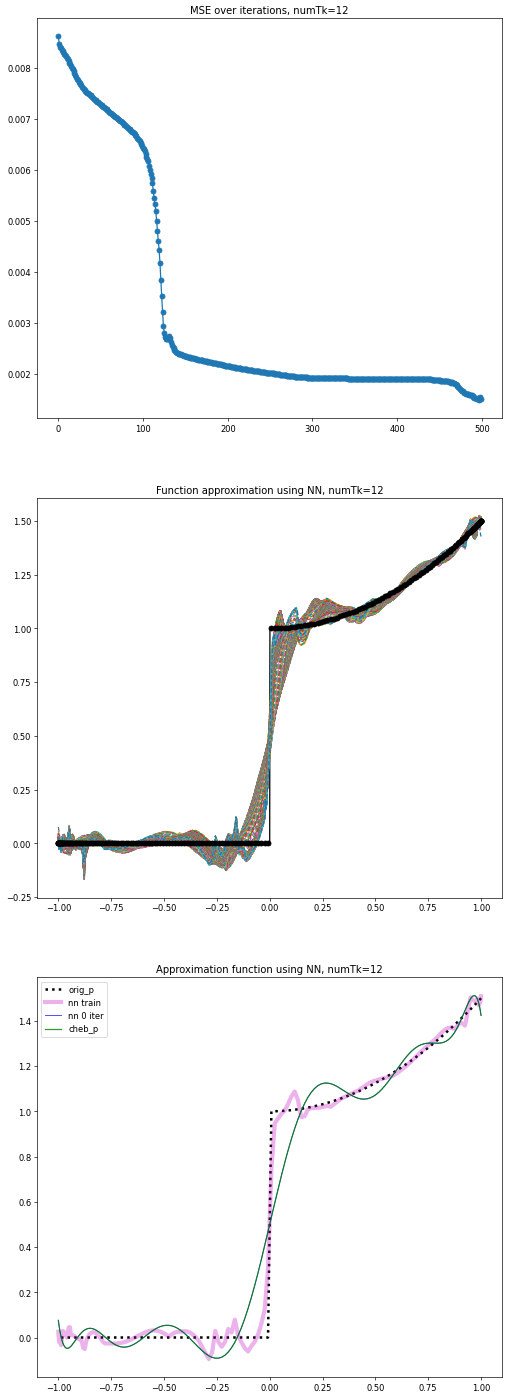

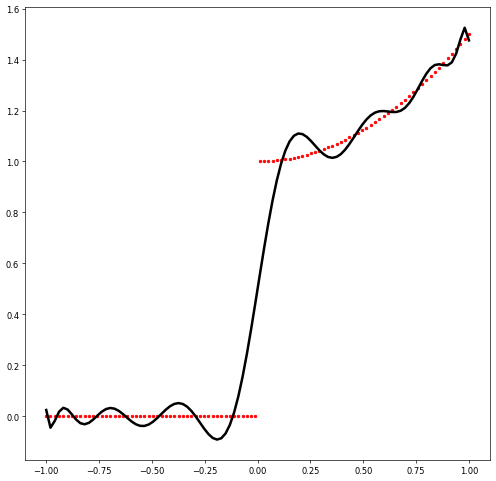

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.0023554298
Cheb pol MSE:  0.006428516470976083


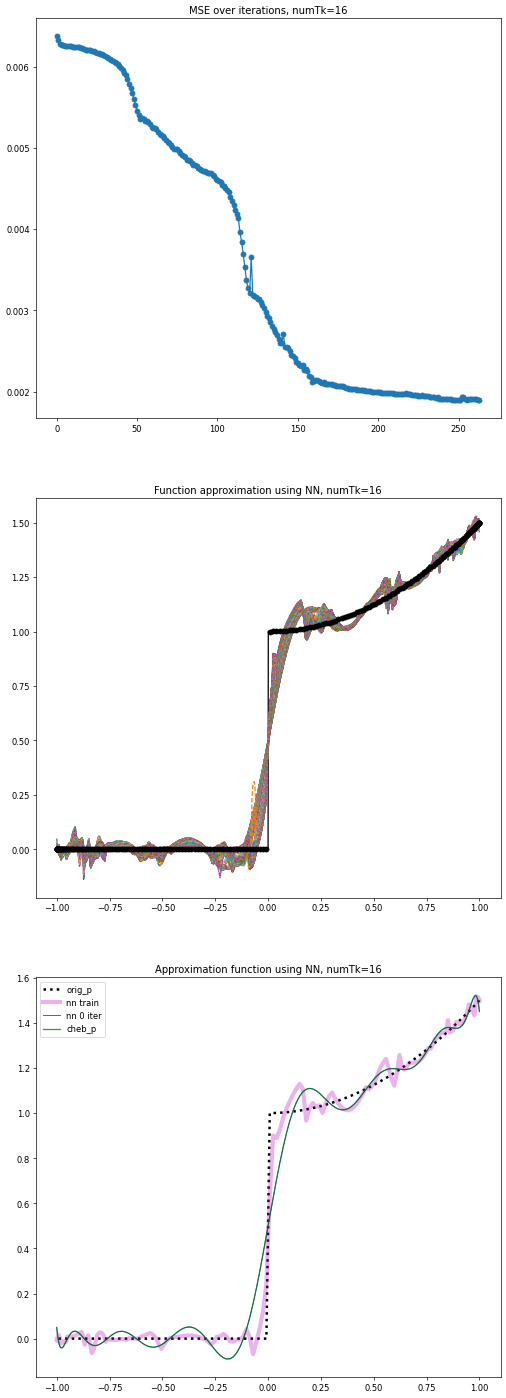

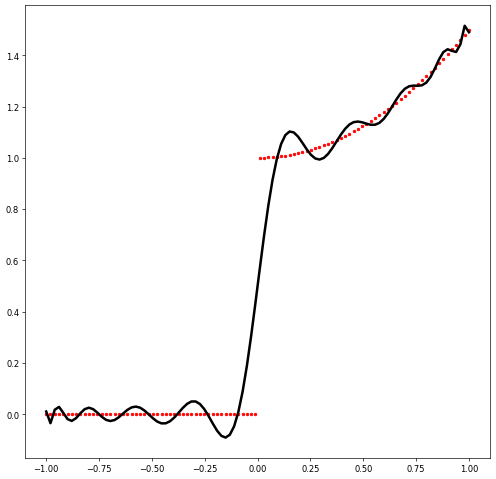

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.0049762735
Cheb pol MSE:  0.00512744342206769


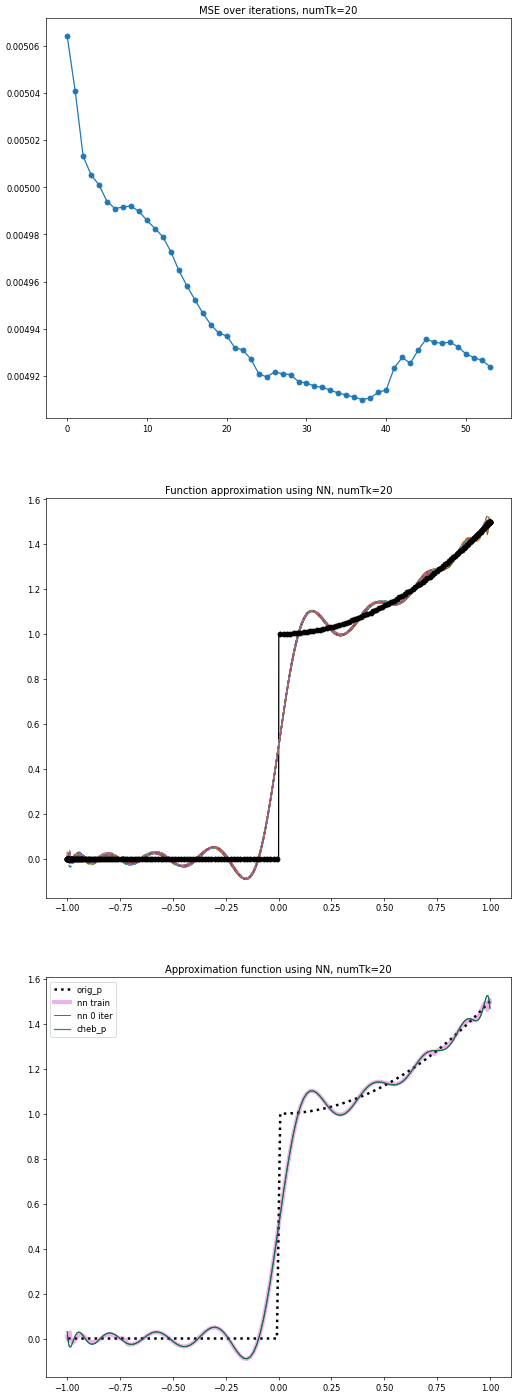

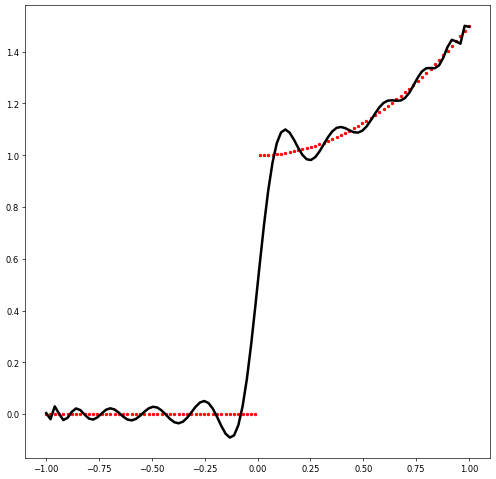

number of h compositions 11
mode Tk_coeff


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Cheb_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_xy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net_x2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


DNN MSE:  0.0038457694
Cheb pol MSE:  0.004277331814083868


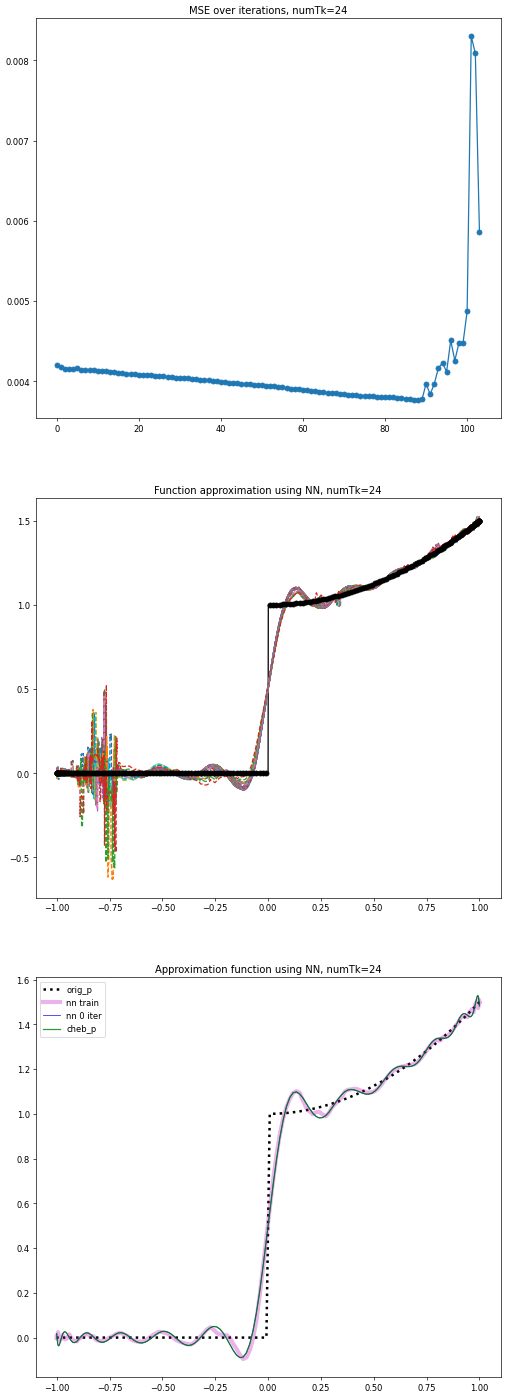

In [0]:
losses_comp = {'nn':[], 'cheb':[]}
for num_Tk in range(4,25,4):
  plot_cheb_approxim(orig_p, num_Tk)
  net, cheb_p, loss, cheb_loss = get_approximation_dnn(num_Tk=num_Tk, orig_p=orig_p, mode="Tk_coeff", eps=0.00001, npoints=200, train=True, loop=500)
  losses_comp['nn'] += [loss]
  losses_comp['cheb'] += [cheb_loss]

[]

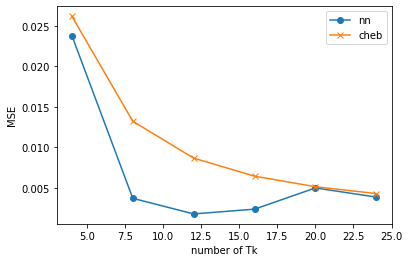

In [0]:
tk_range = np.arange(4,25,4)
plt.plot(tk_range, losses_comp['nn'], marker='o', label='nn')
plt.plot(tk_range, losses_comp['cheb'], marker='x', label='cheb')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('number of Tk')
plt.plot()

# $T_1, T_2, T_3,T_4$ approximation by DNN

number of h compositions 13
mode coeff
w_coeff [[6.6613384e-17 1.0000000e+00]]
[6.66133815e-17 1.00000000e+00]
number of h compositions 13
mode coeff
w_coeff [[-1.1109934e-16  3.0461253e-16  1.0000000e+00]]
[-1.11099337e-16  3.04612521e-16  1.00000000e+00]
number of h compositions 13
mode coeff
w_coeff [[ 8.8030066e-18 -1.2104388e-16  2.7979603e-16  1.0000000e+00]]
[ 8.80300625e-18 -1.21043877e-16  2.79796015e-16  1.00000000e+00]
number of h compositions 13
mode coeff
w_coeff [[-2.0000000e+00  0.0000000e+00 -3.2310624e-17  1.7827868e-16
   1.0000000e+00]]
[-2.00000000e+00  0.00000000e+00 -3.23106244e-17  1.78278678e-16
  1.00000000e+00]


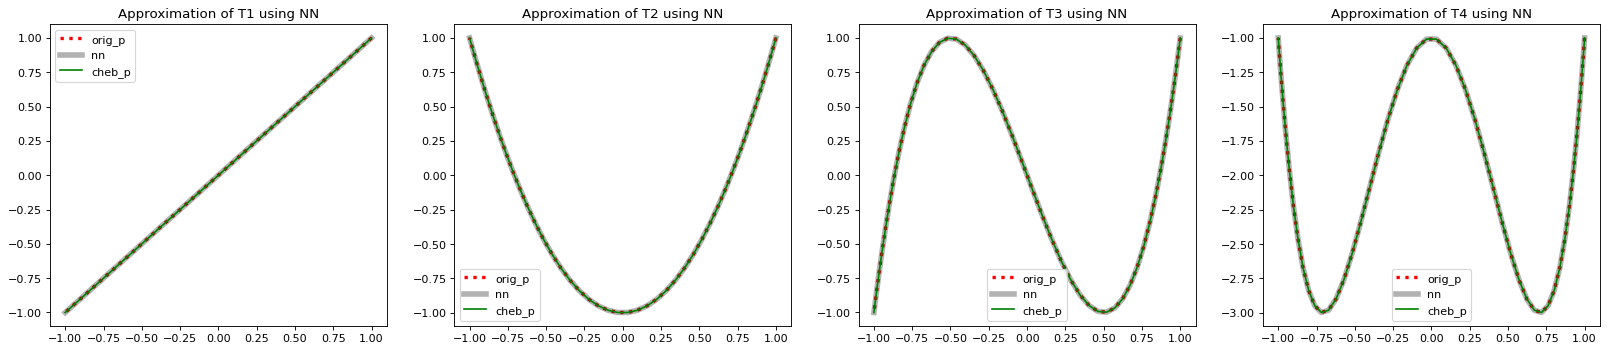

In [47]:
x = np.linspace(first, last, 100)
Tks = [lambda x: x*0+1, lambda x: x, lambda x: 2*x**2-1, lambda x: 2*x*(2*x**2-1)-x, lambda x: 2*x*(2*x*(2*x**2-1)-x) - 2*x**2-1]

criterion = nn.MSELoss()
num_ks = 5
eps = 0.000001

f, axes = plt.subplots(1,num_ks-1, figsize=(5*num_ks,5), dpi=80, facecolor='w', edgecolor='k')

def plot_p_nn(net, idx, orig_p):
    xs, ys = create_data_cheb(50, orig_p)
    nn_ys = net(xs).data.numpy()
    axes[idx].plot(xs.numpy().squeeze(), ys.numpy().squeeze(), ':', label='orig_p', color='r', linewidth=3)
    axes[idx].plot(xs.numpy().squeeze(), nn_ys, color='k', label='nn', linewidth=5, alpha=0.3)
    axes[idx].plot(xs.numpy().squeeze(), cheb_p(xs.numpy().squeeze()), color='g', label='cheb_p')
    axes[idx].legend()



for k in range(1,num_ks):
    Tk = Tks[k]
    y = Tk(x)
    cheb_p = p = np.polynomial.Chebyshev.fit(x, y, k)
    
    Tk_true_coef = cheb_p.coef
    net = Cheb_Net(eps, k, a=first, b=last, w_coeff = Tk_true_coef, mode="coeff")

    for name, param in net.named_parameters():
        if param.requires_grad:
            print(name, param.data.numpy())
    print(Tk_true_coef)  
      
    plot_p_nn(net, k-1, Tk)
    axes[k-1].set_title('Approximation of T%d using NN'%k)


plt.show()

